# Information

- Full paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4374466/

# Libraries

1) Install Anaconda

    - Run 'brew cask install anaconda'
    - Add 'export PATH=/usr/local/anaconda3/bin:"$PATH"' to '.bash_profile' or to '.bashrc'

2) Install MNE (https://martinos.org/mne/stable/install_mne_python.html)

    - Run 'conda --version && python --version'
    - Run:
        - curl -O https://raw.githubusercontent.com/mne-tools/mne-python/master/environment.yml
        - conda env create -f environment.yml
        - source activate mne

## Load libraries

In [1]:
import mne
import scipy.io          as sio
import numpy             as np
import matplotlib.pyplot as plt
from random import randint

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import MinMaxScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition   import PCA, FastICA
from scipy import interp

## Config libraries

In [2]:
mne.set_log_level('INFO')

# Dataset

## Load file

In [3]:
# Load matlab file
# https://docs.scipy.org/doc/scipy/reference/tutorial/io.html
# Load the MATLAB structs as python objects rather than numpy structured arrays (struct_as_record=False)
mat = sio.loadmat('Complete experiment.mat', struct_as_record=False, squeeze_me=True, chars_as_strings=True)

print('Loaded subject {} file'.format('Jose'))

Loaded subject Jose file


# Signals

## Load signals

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html

In [4]:
ch_names      = mat['channelNames'].tolist()
ch_types      = ['eeg'] * len(ch_names)
sampling_rate = mat['samplingFreq']
# Set missing EEG montage (electrode positions)
# https://martinos.org/mne/stable/generated/mne.io.Raw.html#mne.io.Raw.set_montage
# https://mne-tools.github.io/stable/generated/mne.channels.Montage.html
# Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
# https://en.wikipedia.org/wiki/10–20_system_(EEG)
montage       = 'standard_1020'

# https://martinos.org/mne/stable/generated/mne.create_info.html
sig_info = mne.create_info(ch_names, sampling_rate, ch_types, montage)

# Create MNE objects from data array
# https://martinos.org/mne/stable/auto_examples/io/plot_objects_from_arrays.html
sig_data = mat['samples']
sig_mne  = mne.io.RawArray(sig_data.T, sig_info) # https://martinos.org/mne/stable/generated/mne.io.RawArray.html
#sig_mne.pick_types(eeg=True, eog=False) # Restrict the data to the EEG channels
print('Loaded subject {} data'.format('Jose'))

Creating RawArray with float64 data, n_channels=8, n_times=366080
    Range : 0 ... 366079 =      0.000 ...  1464.316 secs
Ready.
Loaded subject Jose data


In [5]:
print('Data from subject {}'.format('Jose'))
print(sig_info)
print(sig_mne)

Data from subject Jose
<Info | 17 non-empty fields
    bads : list | 0 items
    buffer_size_sec : float | 1.0
    ch_names : list | FZ, CZ, P3, PZ, P4, PO7, PO8, OZ
    chs : list | 8 items (EEG: 8)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : list | 11 items
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 125.0 Hz
    nchan : int | 8
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_date : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneTyp

### Set EEG reference

In [6]:
# TODO: Consultar la referencia?
# Setting EEG reference
# https://martinos.org/mne/dev/auto_tutorials/plot_eeg_erp.html#setting-eeg-reference
# Remove the reference
# This explicitly prevents MNE from adding a default EEG average reference required for source localization.
#sig_mne_no_ref, _ = mne.set_eeg_reference(sig_mne, [])

## Sensors

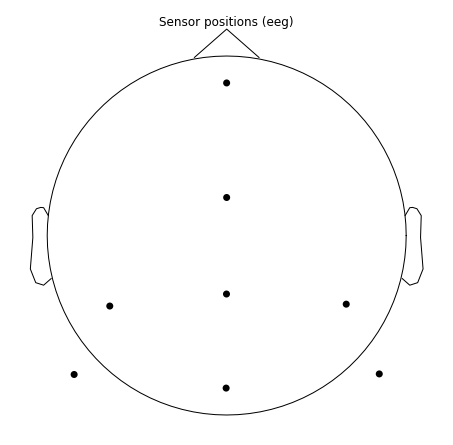

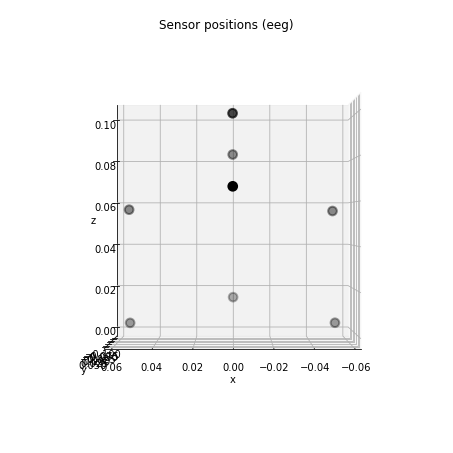

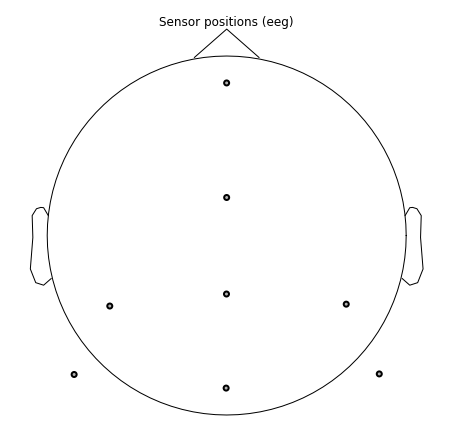

(<Figure size 432x432 with 1 Axes>, [])

In [7]:
# Plot sensors
sig_mne.plot_sensors()
sig_mne.plot_sensors('3d') # in 3D
sig_mne.plot_sensors('select')

## Plot signals

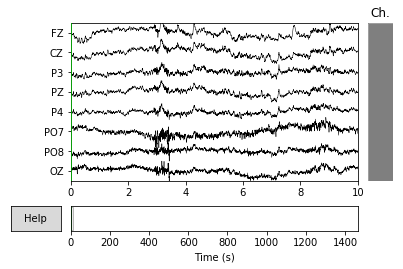

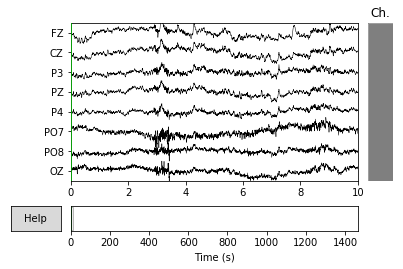

In [8]:
# Plot raw data of first 10 channels
sig_mne.plot(n_channels=8, scalings='auto', block=True)

Effective window size : 8.192 (s)


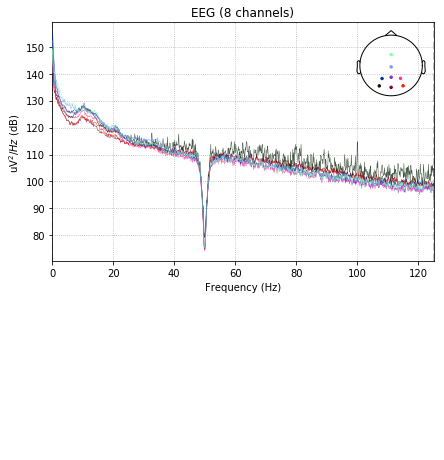

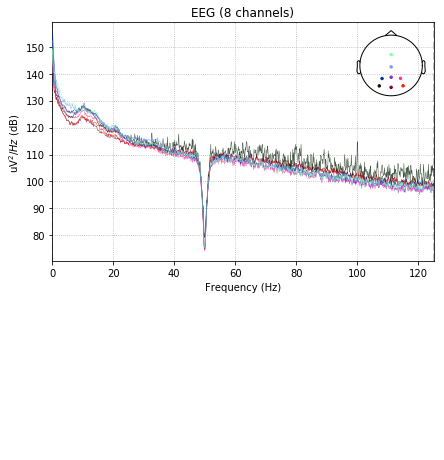

In [9]:
# Compute the power spectral density of raw data
# https://martinos.org/mne/stable/auto_examples/time_frequency/plot_compute_raw_data_spectrum.html
sig_mne.plot_psd()

Setting up band-pass filter from 1 - 20 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 5.0 Hz
Filter length of 825 samples (3.300 sec) selected
Effective window size : 8.192 (s)


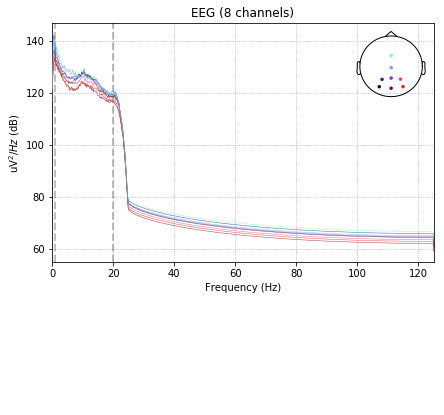

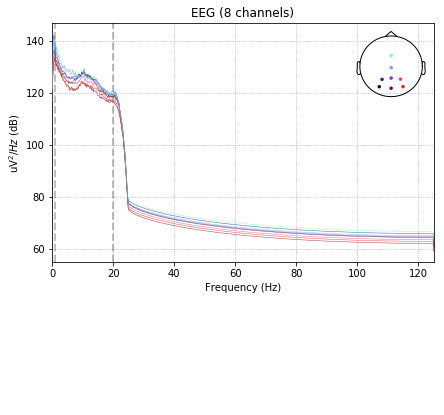

In [10]:
# Band-pass filter data
sig_mne.filter(l_freq=1.0, h_freq=20.0)

# Plot the power spectral density across filtered channels
sig_mne.plot_psd()

In [11]:
# start, stop = raw.time_as_index([100, 115])  # 100 s to 115 s data segment
# data, times = raw[:, start:stop]
# print(data.shape)
# print(times.shape)
# data, times = raw[2:20:3, start:stop]  # access underlying data
# raw.plot()

# Events

## Load events

- https://martinos.org/mne/stable/auto_tutorials/plot_creating_data_structures.html
- https://martinos.org/mne/stable/auto_examples/io/plot_read_events.html#ex-read-events

In [12]:
def get_stims_as_channel(stims, sample_times):
    epochs_with_events = list()
    event_index = 0
    add_counter = -1
    event_type = 0

    for sample_time in sample_times:
        if add_counter == -1 and event_index < len(stims) and sample_time >= stims[event_index][0]:
            event_type = stims[event_index][1]
            add_counter = 1
        elif add_counter == 500:
            event_type = 0
            if event_index < len(stims):
                add_counter = -1
                event_index += 1
        elif add_counter >= 0:
            add_counter += 1
        event_type = 0.0 if event_type == 3.0 else event_type
        event_type = 1.0 if event_type == 4.0 else event_type
        epochs_with_events.append(int(event_type))
    return np.array(epochs_with_events)

def get_hits_as_channel(ee_values):
    ee_hits = list()
    for ee_value in ee_values:
        ee_hits.append(1 if ee_value == 2 else 0)
    return np.array(ee_hits)

In [13]:
# Adds event channel with angle values
ee_ch_name  = 't_type'
ee_ch_type  = 'misc'
ee_tmin     = 0.0
ee_tmax     = 2.0

# Create info
sig_events_info = mne.create_info(
    ch_names = ch_names + [ee_ch_name],
    ch_types = ch_types + [ee_ch_type],
    sfreq    = sampling_rate,
    montage  = 'standard_1020'
)

# Create raw
ee_angles_data  = get_stims_as_channel(mat['stims'], mat['sampleTime'])
ee_angles_id    = list(set(ee_angles_data) - {0, 1}) # list of event values
sig_events_data = np.c_[sig_data, ee_angles_data] # https://stackoverflow.com/q/20978757/3349531
sig_events_mne  = mne.io.RawArray(sig_events_data.T, sig_events_info)

print('Events values = {}'.format(ee_angles_id))

Creating RawArray with float64 data, n_channels=9, n_times=366080
    Range : 0 ... 366079 =      0.000 ...  1464.316 secs
Ready.
Events values = [2]


In [14]:
# Find events
# https://martinos.org/mne/stable/generated/mne.find_events.html
ee_events = mne.find_events(sig_events_mne, stim_channel=ee_ch_name)

702 events found
Event IDs: [1 2]


In [15]:
# Find epochs
sig_events_epochs = mne.Epochs(sig_mne, ee_events, ee_angles_id, tmin=ee_tmin, tmax=ee_tmax)

print('Loaded (#Epochs, #Channels, #Times) = {}'.format(sig_events_epochs.get_data().shape))

331 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 331 events and 501 original time points ...
0 bad epochs dropped
Loaded (#Epochs, #Channels, #Times) = (331, 8, 501)


## Plot events

- https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

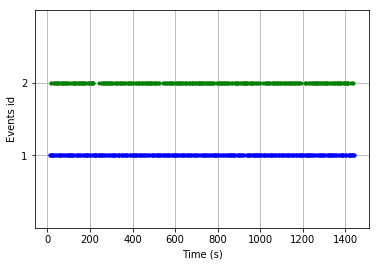

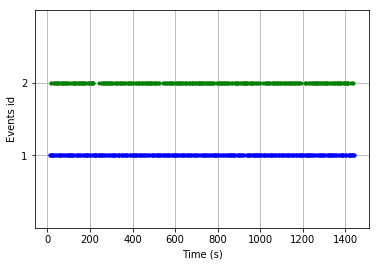

In [16]:
# Plot all events
mne.viz.plot_events(ee_events, sfreq=sampling_rate) # https://martinos.org/mne/stable/generated/mne.viz.plot_events.html

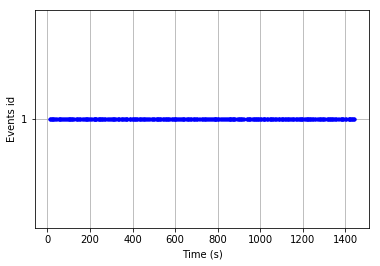

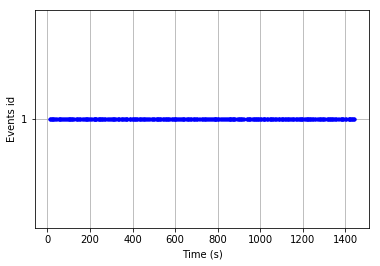

In [17]:
# Plot [1] events
ee_events_1 = mne.pick_events(ee_events, include=[1])
mne.viz.plot_events(ee_events_1, sfreq=sampling_rate)

## Plot epochs

https://martinos.org/mne/stable/auto_tutorials/plot_visualize_epochs.html

Loading data for 331 events and 501 original time points ...
Loading data for 20 events and 501 original time points ...


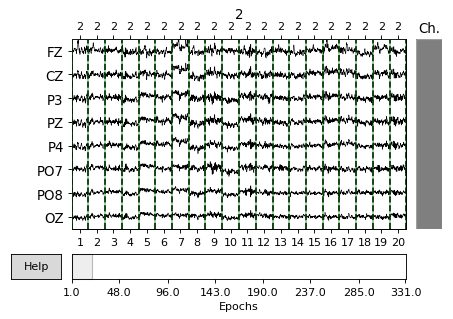

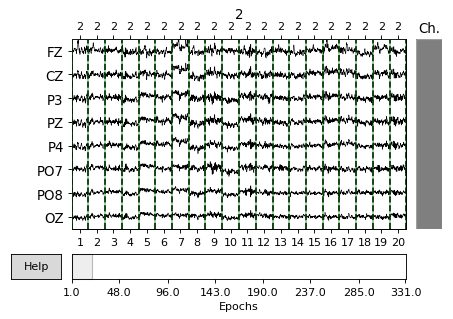

In [18]:
sig_events_epochs.plot(scalings='auto', block=True)

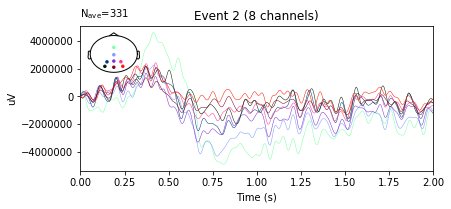

In [19]:
# Plot average for each event type
for each in ee_angles_id:
    event_type = str(each)
    sig_events_epochs[event_type].average().plot(titles=('Event ' + event_type), time_unit='s', spatial_colors=True)

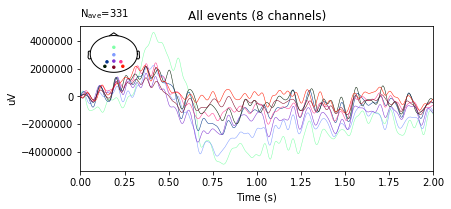

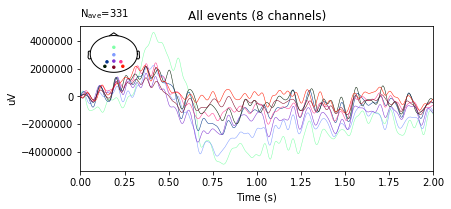

In [20]:
# Plot average for all types
sig_events_epochs.average().plot(titles=('All events'), time_unit='s', spatial_colors=True)

# Analisys

## Load data

In [21]:
ee_hits_data  = get_hits_as_channel(ee_angles_data)
ee_hits_id    = list(set(ee_hits_data))
ee_hits_id

[0, 1]

In [22]:
target_names = ['nohit', 'hit']

# Create raw
ee_hits_data  = get_hits_as_channel(ee_angles_data)
ee_hits_id    = list(set(ee_hits_data)) # list of event values
sig_hits_data = np.c_[sig_data, ee_hits_data] # https://stackoverflow.com/q/20978757/3349531
sig_hits_mne  = mne.io.RawArray(sig_hits_data.T, sig_events_info)

print('Events values = {}'.format(ee_hits_id))

# Find events
ee_hits = mne.find_events(sig_hits_mne, stim_channel=ee_ch_name, output='step', initial_event=True, consecutive=True)

# Find epochs
hits_epochs        = mne.Epochs(sig_mne, ee_hits, ee_hits_id, tmin=ee_tmin, tmax=ee_tmax, proj=False, baseline=None, preload=True)
hits_epochs_labels = hits_epochs.events[:, -1]
print(type(hits_epochs_labels))

# random labels
# hits_epochs_labels = np.asarray([randint(0,1) for i in range(len(hits_epochs_labels))])

print('Loaded (#Epochs, #Channels, #Times) = {}'.format(hits_epochs.get_data().shape))

Creating RawArray with float64 data, n_channels=9, n_times=366080
    Range : 0 ... 366079 =      0.000 ...  1464.316 secs
Ready.
Events values = [0, 1]
662 events found
Event IDs: [0 1]


ValueError: You have 129 events shorter than the shortest_event. These are very unusual and you may want to set min_duration to a larger value e.g. x / raw.info['sfreq']. Where x = 1 sample shorter than the shortest event length.

## Principal component analysis

### PCA

In [ ]:
pca             = mne.decoding.UnsupervisedSpatialFilter(PCA(n_components=4), average=False)
pca_data        = pca.fit_transform(hits_epochs.get_data())
pca_data_evoked = mne.EvokedArray(np.mean(pca_data, axis=0), mne.create_info(4, sampling_rate, ch_types='eeg'), tmin=ee_tmin)
pca_data_evoked.plot(show=False, window_title="PCA", time_unit='s')

# Initialize
pca_pipeline = make_pipeline(
    mne.decoding.Vectorizer(), # Transform n-dimensional array into 2D array of n_samples by n_features.
    MinMaxScaler(), # Transforms features by scaling each feature to a given range (0, 1).
    LogisticRegression(penalty='l1') # linear model for classification
)
pca_cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross validation
pca_predictions = np.empty(len(hits_epochs_labels))
for train_index, test_index in pca_cross_validator.split(pca_data, hits_epochs_labels):
    print("TRAIN SIZE:", len(train_index), 'TEST SIZE:', len(test_index))
    data_train, data_test       = pca_data[train_index], pca_data[test_index]
    labels_train                = hits_epochs_labels[train_index]
    pca_pipeline_fit            = pca_pipeline.fit(data_train, labels_train)
    pca_predictions[test_index] = pca_pipeline_fit.predict(data_test)

# Classification report
pca_report = classification_report(hits_epochs_labels, pca_predictions, target_names=target_names)
print(pca_report)

# Confusion matrix
pca_confusion_m = confusion_matrix(hits_epochs_labels, pca_predictions)
print("Confusion matrix")
print(pca_confusion_m)

# Normalized confusion matrix
pca_confusion_m_norm = pca_confusion_m.astype(float) / pca_confusion_m.sum(axis=1)[:, np.newaxis]
plt.imshow(pca_confusion_m_norm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(target_names))
plt.title('Normalized Confusion matrix')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, target_names, rotation=45)
plt.ylabel('True label')
plt.yticks(tick_marks, target_names)
plt.colorbar()
mne.viz.tight_layout()
plt.show()

# ROC
pca_confidence_scores = pca_pipeline_fit.decision_function(pca_data)
pca_fpr, pca_tpr, _   = roc_curve(hits_epochs_labels, pca_confidence_scores)
pca_roc_auc           = roc_auc_score(hits_epochs_labels, pca_confidence_scores)
plt.figure()
plt.title('ROC')
plt.plot(pca_fpr, pca_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % pca_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

### ICA

In [ ]:
# Use unsupervised spatial filtering across time and samples
ica             = mne.decoding.UnsupervisedSpatialFilter(FastICA(n_components=4), average=False)
ica_data        = ica.fit_transform(hits_epochs.get_data())
ica_data_evoked = mne.EvokedArray(np.mean(ica_data, axis=0), mne.create_info(4, sampling_rate, ch_types='eeg'), tmin=ee_tmin)
ica_data_evoked.plot(show=False, window_title="ICA", time_unit='s')

# Initialize
ica_pipeline = make_pipeline(
    mne.decoding.Vectorizer(), # Transform n-dimensional array into 2D array of n_samples by n_features.
    MinMaxScaler(), # Transforms features by scaling each feature to a given range (0, 1).
    LogisticRegression(penalty='l1') # linear model for classification
)
ica_cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Do cross validation
ica_predictions = np.empty(len(hits_epochs_labels))
for train_index, test_index in ica_cross_validator.split(ica_data, hits_epochs_labels):
    print("TRAIN SIZE:", len(train_index), 'TEST SIZE:', len(test_index))
    data_train, data_test       = ica_data[train_index], ica_data[test_index]
    labels_train                = hits_epochs_labels[train_index]
    ica_pipeline_fit            = ica_pipeline.fit(data_train, labels_train)
    ica_predictions[test_index] = ica_pipeline_fit.predict(data_test)

# Classification report
ica_report = classification_report(hits_epochs_labels, ica_predictions, target_names=target_names)
print(ica_report)

# Confusion matrix
ica_confusion_m = confusion_matrix(hits_epochs_labels, ica_predictions)
print("Confusion matrix")
print(ica_confusion_m)

# Normalized confusion matrix
ica_confusion_m_norm = ica_confusion_m.astype(float) / ica_confusion_m.sum(axis=1)[:, np.newaxis]
plt.imshow(ica_confusion_m_norm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(target_names))
plt.title('Normalized Confusion matrix')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, target_names, rotation=45)
plt.ylabel('True label')
plt.yticks(tick_marks, target_names)
plt.colorbar()
mne.viz.tight_layout()
plt.show()

# ROC
ica_confidence_scores = ica_pipeline_fit.decision_function(ica_data)
ica_fpr, ica_tpr, _   = roc_curve(hits_epochs_labels, ica_confidence_scores)
ica_roc_auc           = roc_auc_score(hits_epochs_labels, ica_confidence_scores)
plt.figure()
plt.title('ROC')
plt.plot(ica_fpr, ica_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % ica_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Train

- http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- http://scikit-learn.org/stable/tutorial/basic/tutorial.html

In [ ]:
# Set classification pipeline
# TODO: Test classificators
classification_pipeline = make_pipeline(
                    mne.decoding.Vectorizer(), # Transform n-dimensional array into 2D array of n_samples by n_features.
                    MinMaxScaler(), # Transforms features by scaling each feature to a given range (0, 1).
                    LogisticRegression(penalty='l2') # linear model for classification
)

# Set cross-validator
# Stratified K-Folds cross-validator
# Provides train/test indices to split data in train/test sets
# This cross-validation object is a variation of KFold that returns stratified folds
# Stratification is done based on the labels provided in split(_, labels)
# The folds are made by preserving the percentage of samples for each class
# https://machinelearningmastery.com/k-fold-cross-validation/
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [ ]:
# Do cross-validation
predictions = np.empty(len(hits_epochs_labels))
tprs        = []
aucs        = []
mean_fpr    = np.linspace(0, 1, len(hits_epochs_labels))

for train_index, test_index in cross_validator.split(hits_epochs, hits_epochs_labels):
    data_train, data_test       = hits_epochs[train_index], hits_epochs[test_index]
    labels_train                = hits_epochs_labels[train_index]
    labels_test                 = hits_epochs_labels[test_index]
    classification_pipeline_fit = classification_pipeline.fit(data_train, labels_train)
    predictions[test_index]     = classification_pipeline_fit.predict(data_test)
    
    probas_                     = classification_pipeline_fit.predict_proba(data_test)
    fpr, tpr, _                 = roc_curve(labels_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0]                 = 0.0
    roc_auc                     = roc_auc_score(labels_test, probas_[:, 1])
    aucs.append(roc_auc)

## Results

In [ ]:
# Classification report
report = classification_report(hits_epochs_labels, predictions, target_names=target_names)
print(report)

In [ ]:
# Confusion matrix
confusion_m = confusion_matrix(hits_epochs_labels, predictions)
print("Confusion matrix")
print(confusion_m)

# Normalized confusion matrix
confusion_m_norm = confusion_m.astype(float) / confusion_m.sum(axis=1)[:, np.newaxis]

# Plot it
plt.imshow(confusion_m_norm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(target_names))
plt.title('Normalized Confusion matrix')
plt.xlabel('Predicted label')
plt.xticks(tick_marks, target_names, rotation=45)
plt.ylabel('True label')
plt.yticks(tick_marks, target_names)
plt.colorbar()
mne.viz.tight_layout()
plt.show()

In [ ]:
# # Compute prediction scores
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_roc_auc = np.mean(aucs)

# Plot ROC
plt.figure()
plt.title('ROC')
plt.plot(mean_fpr, mean_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % mean_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

## Test different classification algotithms

- Choosing the right estimator: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
- http://scikit-learn.org/stable/tutorial/basic/tutorial.html
- http://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
from sklearn.pipeline     import Pipeline
from sklearn.svm          import LinearSVC, SVC
from sklearn.neighbors    import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression

multi_classification_pipeline = Pipeline([
    ('vectorizer', mne.decoding.Vectorizer()),
    ('normalizer', MinMaxScaler()),
    ('classifier', LogisticRegression(penalty='l1'))
])
multi_cross_validator = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

classifiers = [
    LinearSVC(), # http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
    KNeighborsClassifier(n_neighbors=5), # http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    SVC(), # http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    SGDClassifier(), # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
    LogisticRegression(), # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
]

for classifier in classifiers:
    print('Classifier', str(classifier))
    multi_classification_pipeline.set_params(classifier=classifier)
    multi_predictions = np.empty(len(hits_epochs_labels))
    for train_index, test_index in multi_cross_validator.split(hits_epochs, hits_epochs_labels):
        print("TRAIN SIZE:", len(train_index), 'TEST SIZE:', len(test_index))
        data_train, data_test             = hits_epochs[train_index], hits_epochs[test_index]
        labels_train                      = hits_epochs_labels[train_index]
        multi_classification_pipeline_fit = multi_classification_pipeline.fit(data_train, labels_train)
        multi_predictions[test_index]     = multi_classification_pipeline.predict(data_test)
    multi_report = classification_report(hits_epochs_labels, multi_predictions, target_names=target_names)
    print(multi_report)
